In [1]:
import os
os.chdir("../../../")

In [2]:
import scanpy as sc
import surgeon
import numpy as np

Using TensorFlow backend.
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mohsen/miniconda3

In [3]:
sc.settings.set_figure_params(dpi=200)

In [4]:
condition_key = "study"
cell_type_key = 'cell_type'
target_conditions = ["Tabula_muris", "Zeisel"]

# Loading mouse brain datasets and data preparation

In [5]:
adata = sc.read("./data/mouse_brain/mouse_brain_normalized.h5ad")
adata

AnnData object with n_obs × n_vars = 56399 × 2000 
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'age', 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'class', 'cluster', 'cluster_id', 'louvain', 'reason', 'refined_class', 'region', 'region_subcluster', 'sample_type', 'study', 'subcluster', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

## Number of cells in each batch

In [6]:
adata.obs[condition_key].value_counts()

Saunders        34502
Tabula_muris     7856
Zeisel           7394
Rosenberg        6647
Name: study, dtype: int64

In [7]:
adata.obs.groupby([cell_type_key,condition_key ]).size()

cell_type                       study       
astrocyte                       Rosenberg         521
                                Saunders         2850
                                Tabula_muris      472
                                Zeisel           1059
brain pericyte                  Rosenberg          49
                                Saunders          562
                                Tabula_muris      156
                                Zeisel            281
endothelial cell                Rosenberg          28
                                Saunders         2244
                                Tabula_muris      715
                                Zeisel            392
ependymal cell                  Rosenberg          25
                                Saunders           94
                                Zeisel             79
macrophage                      Rosenberg           2
                                Saunders          107
                                Tabul

## visualization  of the original data

In [8]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/mohsen/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


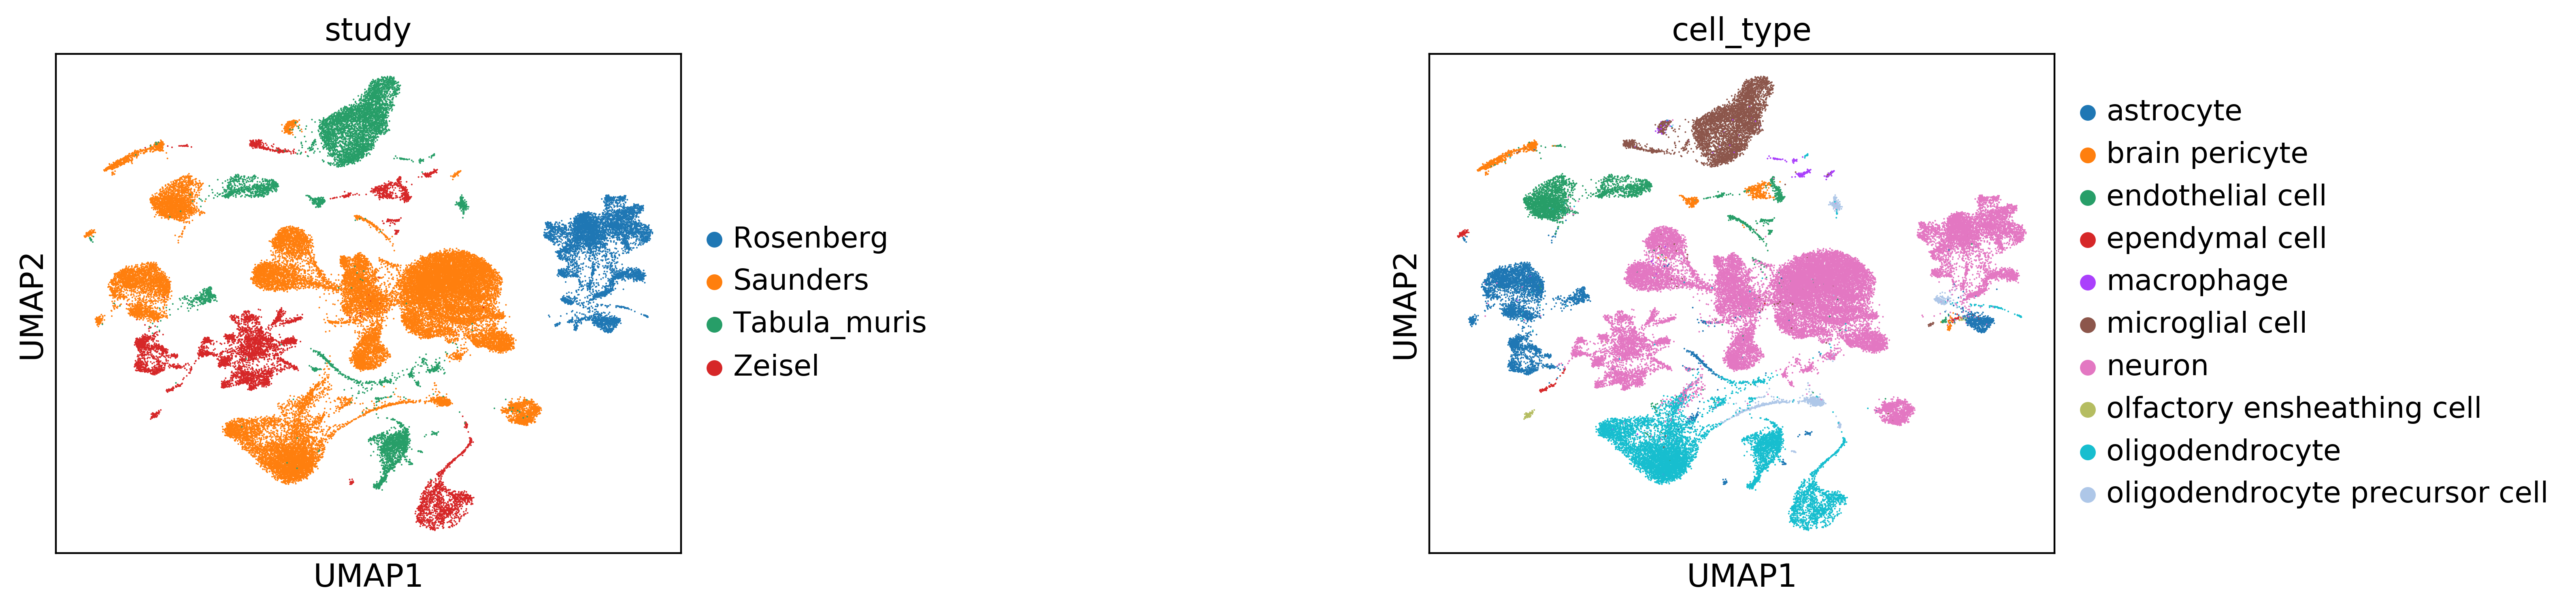

In [9]:
sc.pl.umap(adata, color=[condition_key, cell_type_key], wspace=1.0)

## Now we leave out one study  (10X_v3) for training the newtork

In [8]:
adata_for_training = adata[~adata.obs[condition_key].isin(target_conditions)]
adata_for_training

View of AnnData object with n_obs × n_vars = 41149 × 2000 
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'age', 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'class', 'cluster', 'cluster_id', 'louvain', 'reason', 'refined_class', 'region', 'region_subcluster', 'sample_type', 'study', 'subcluster', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

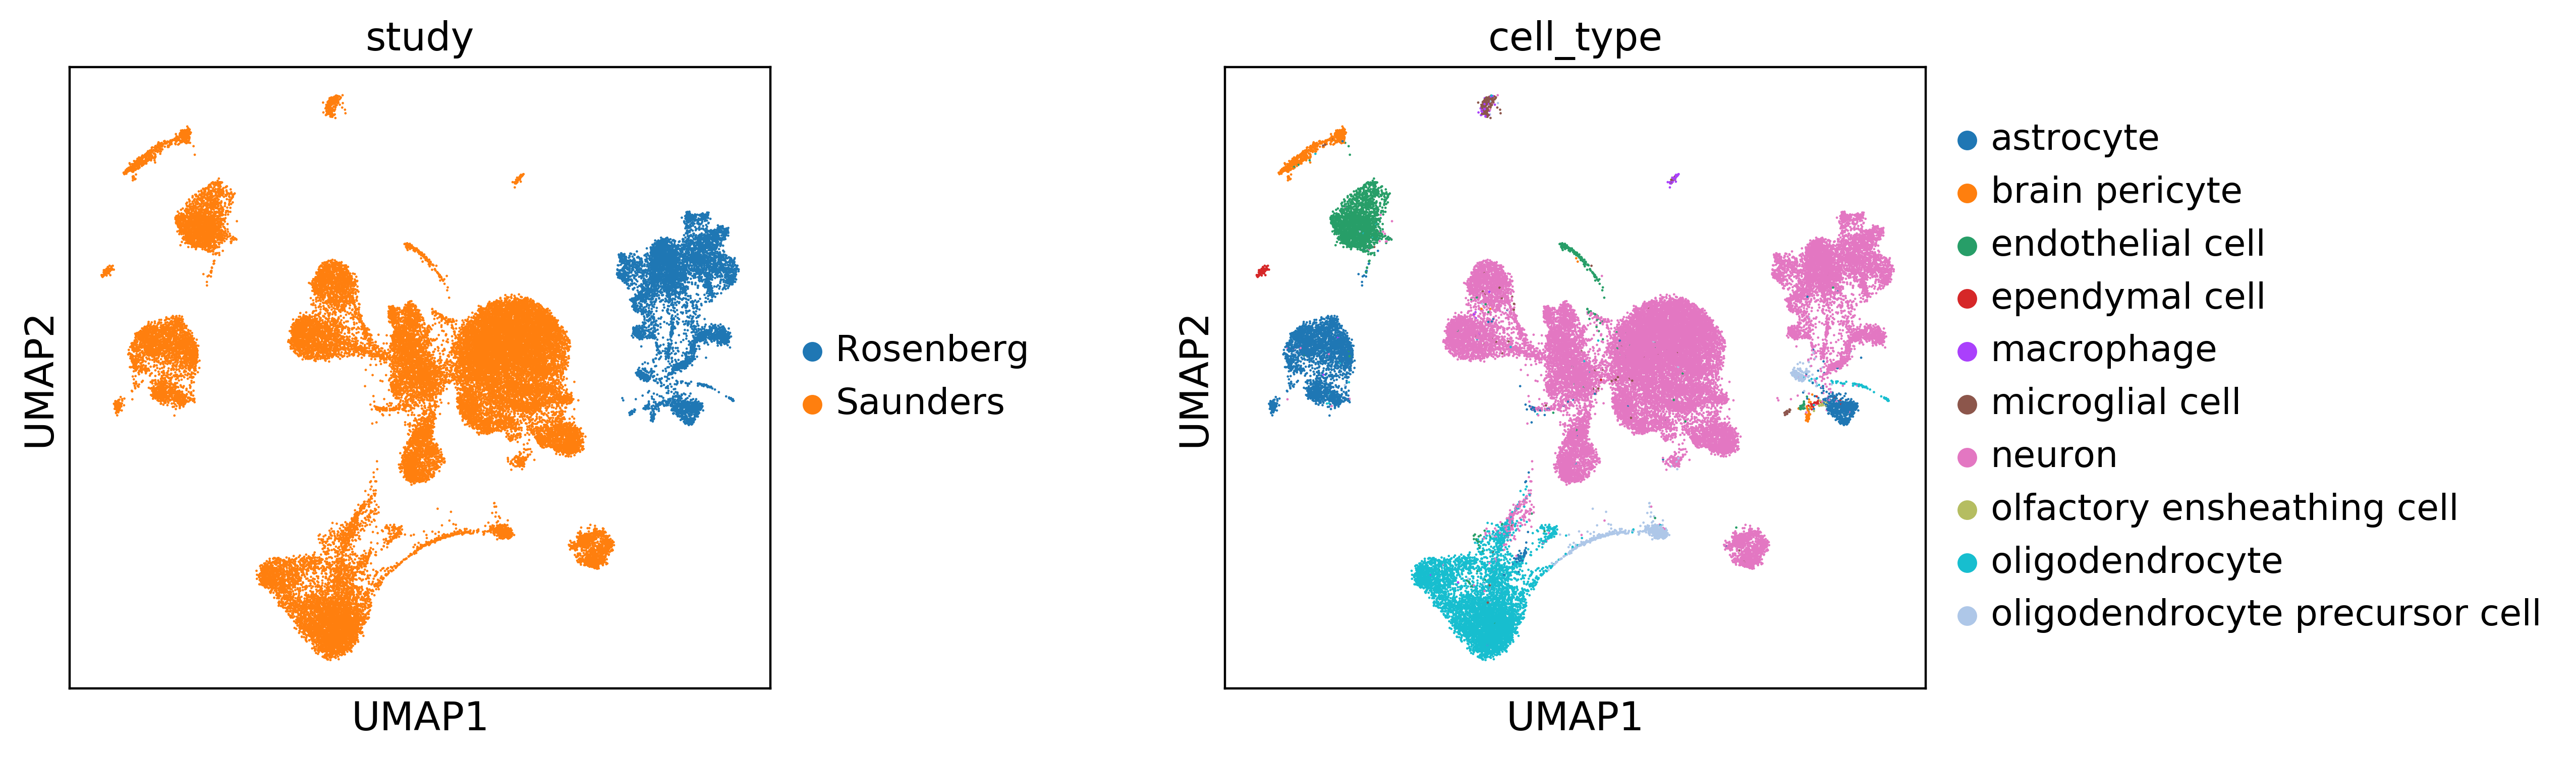

In [12]:
sc.pl.umap(adata_for_training, color=[condition_key, cell_type_key], wspace=0.5)

In [9]:
adata_out_of_sample = adata[adata.obs[condition_key].isin(target_conditions)]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 15250 × 2000 
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'age', 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'class', 'cluster', 'cluster_id', 'louvain', 'reason', 'refined_class', 'region', 'region_subcluster', 'sample_type', 'study', 'subcluster', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

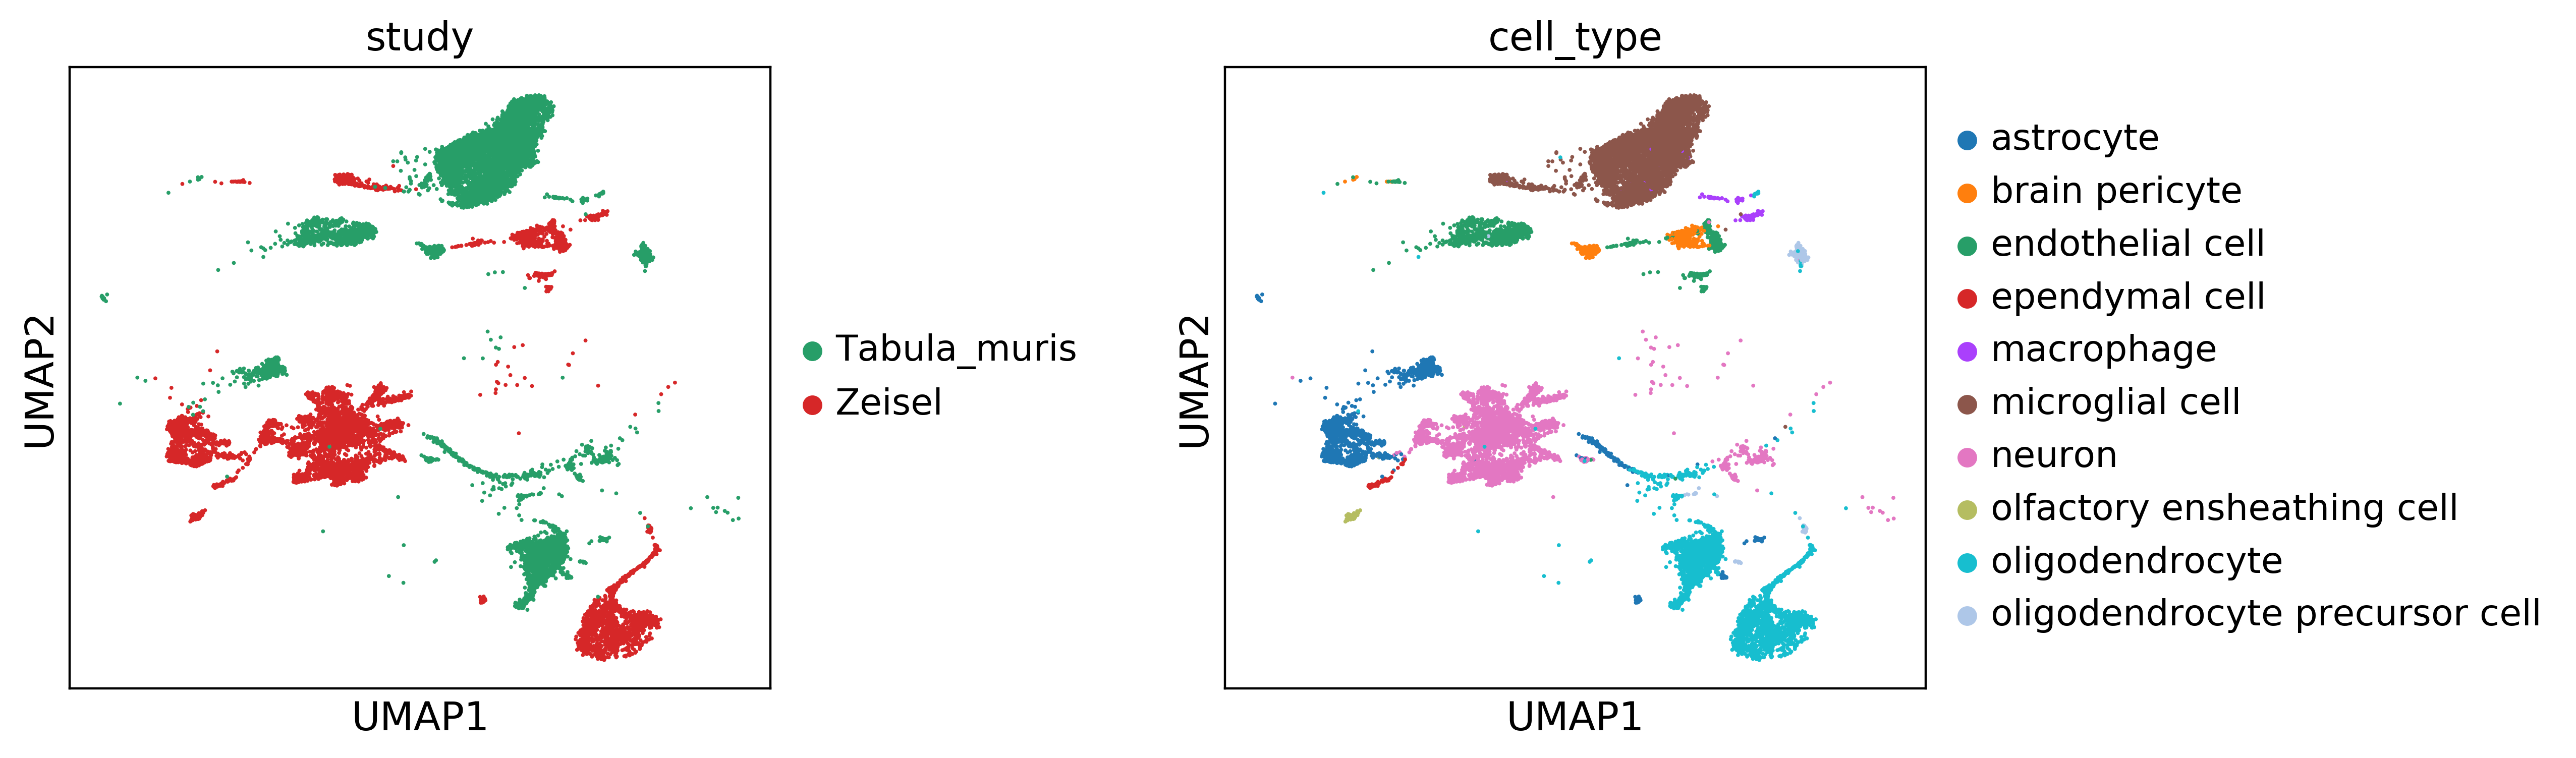

In [14]:
sc.pl.umap(adata_out_of_sample, color=[condition_key, cell_type_key], wspace=0.5)

## Train/Test Split

In [10]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_for_training, 0.80)

In [11]:
train_adata.shape, valid_adata.shape

((32919, 2000), (8230, 2000))

In [12]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())

# Create & Train model with training data

In [13]:
network = surgeon.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=10,
                             architecture=[128, 64, 32],
                             n_conditions=n_conditions,
                             use_batchnorm=False,
                             lr=0.001,
                             alpha=0.00005,
                             beta=1000,
                             eta=1.0,
                             clip_value=1000.0,
                             loss_fn='mse',
                             model_path="./models/CVAE/mouse_brain/before/",
                             dropout_rate=0.05,
                             output_activation='relu')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 2)            0                                            
__________________________________________________________________________________________________
first_layer (FirstLayer)        (None, 128)          256256      data[0][0]                       
                                                                 encoder_labels[0][0]             
_____________________

## We assign each study to a numerical label 

In [14]:
train_adata.obs[condition_key].value_counts()

Saunders     27641
Rosenberg     5278
Name: study, dtype: int64

In [15]:
conditions = adata.obs[condition_key].unique().tolist()
condition_encoder = surgeon.utils.create_dictionary(conditions, target_conditions)
condition_encoder

{'Saunders': 0, 'Rosenberg': 1}

## Training the network

In [ ]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              le=condition_encoder, 
              n_epochs=10000,
              n_per_epoch=0,
              batch_size=1024, 
              early_stop_limit=50,
              lr_reducer=40, 
              save=True, 
              retrain=True,
              verbose=20)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10000:
 - loss: 88.0420 - kl_sse_loss: 72.4820 - mmd_loss: 15.5595 - val_loss: 76.2403 - val_kl_sse_loss: 67.9371 - val_mmd_loss: 8.3027
Epoch 21/10000:
 - loss: 48.4883 - kl_sse_loss: 43.2047 - mmd_loss: 5.2830 - val_loss: 47.2235 - val_kl_sse_loss: 42.1816 - val_mmd_loss: 5.0413
Epoch 41/10000:
 - loss: 44.1855 - kl_sse_loss: 40.3010 - mmd_loss: 3.8839 - val_loss: 43.7150 - val_kl_sse_loss: 39.7648 - val_mmd_loss: 3.9495
Epoch 61/10000:
 - loss: 42.5678 - kl_sse_loss: 38.9418 - mmd_loss: 3.6252 - val_loss: 42.2594 - val_kl_sse_loss: 38.5150 - val_mmd_loss: 3.7436
Epoch 81/10000:
 - loss: 41.5320 - kl_sse_loss: 38.1190 - mmd_loss: 3.4122 - val_loss: 41.1170 - val_kl_sse_loss: 37.6395 - val_mmd_loss: 3.4767
Epoch 101/10000:
 - loss: 40.6537 - kl_sse_loss: 37.5201 - mmd_loss: 3.1326 - val_loss: 40.2810 - val_kl_sse_loss: 37.1170 - val_mmd_loss: 3.1632
Epoch 121/10000:
 - loss: 40.1890 - kl_sse_loss: 37.1028 - mmd_loss: 3.0852 - val

In [25]:
network.condition_encoder

{'Saunders': 0, 'Rosenberg': 1}

In [26]:
encoder_labels, _ = surgeon.utils.label_encoder(
    adata_for_training, label_encoder=network.condition_encoder, condition_key=condition_key)

In [27]:
latent_adata = network.to_mmd_layer(adata_for_training, encoder_labels, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 41149 × 32 
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'age', 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'class', 'cluster', 'cluster_id', 'louvain', 'reason', 'refined_class', 'region', 'region_subcluster', 'sample_type', 'study', 'subcluster', 'n_counts'

In [28]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

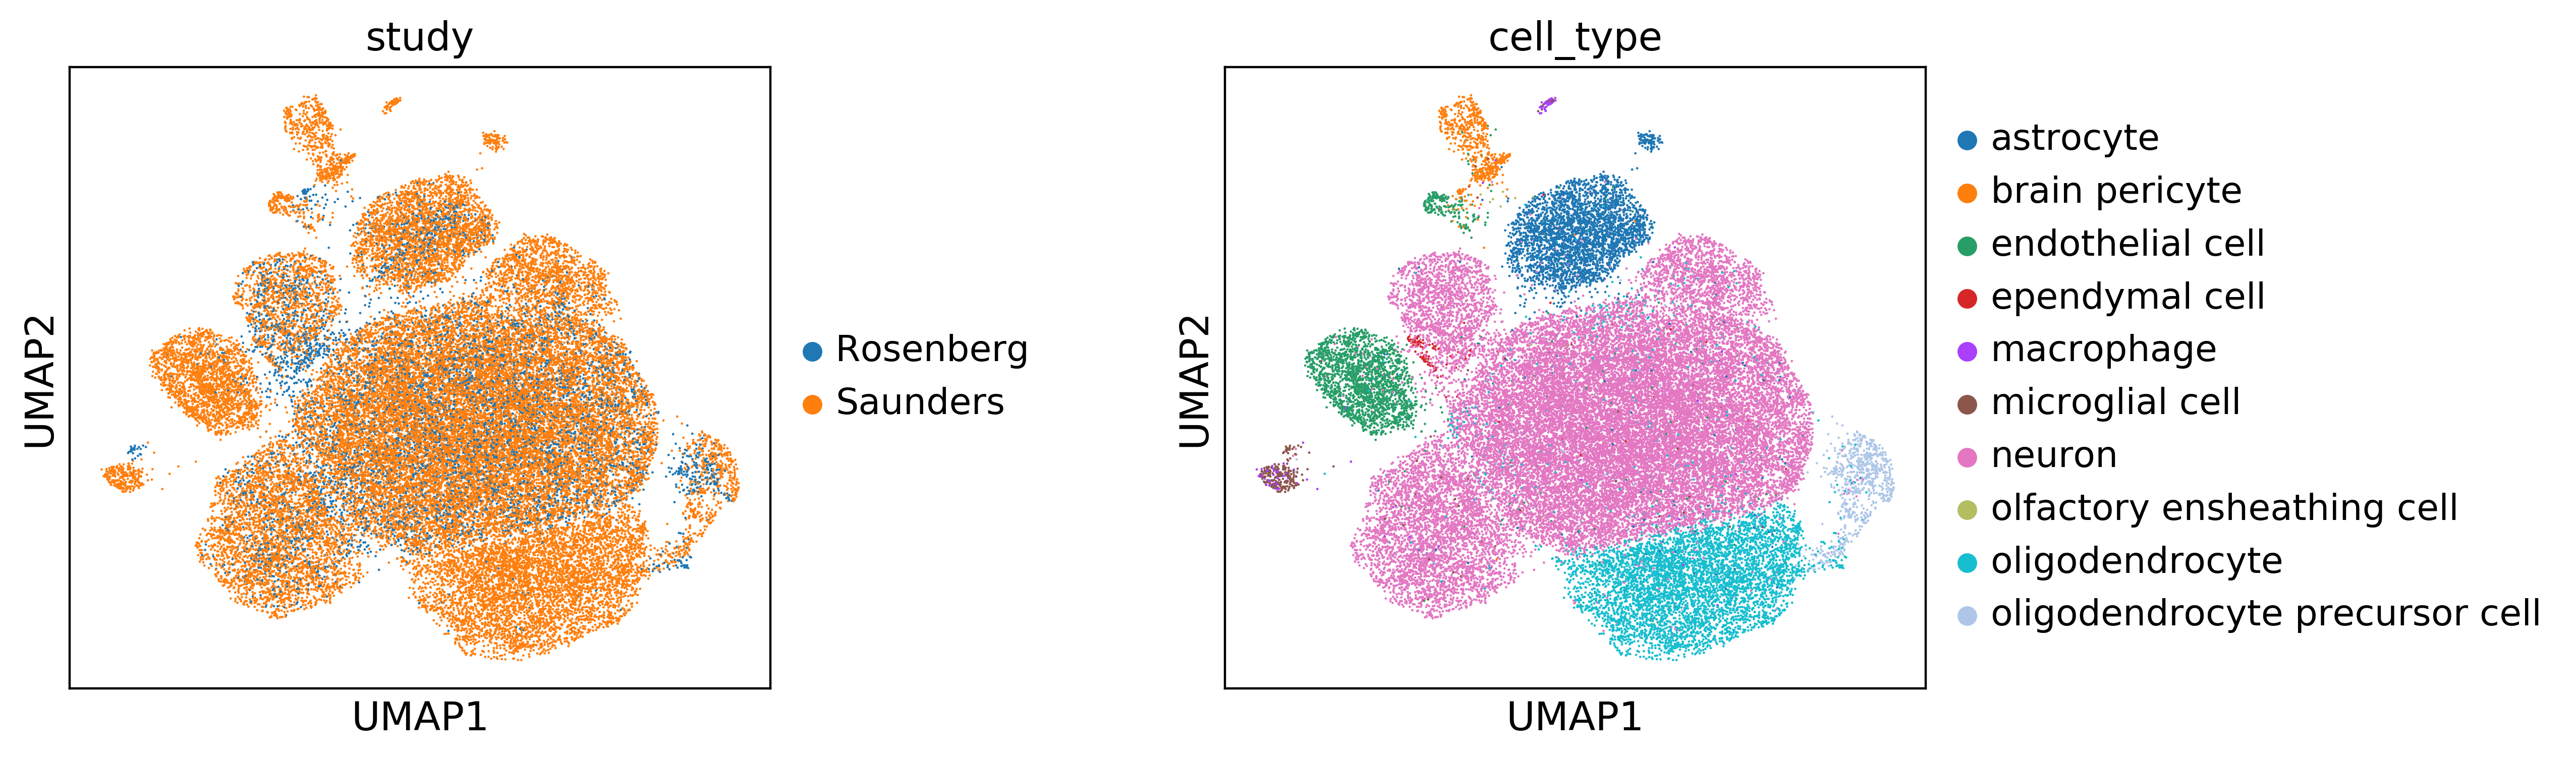

In [29]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

In [30]:
surgeon.metrics.entropy_batch_mixing(latent_adata, condition_key, n_neighbors=15)

0.22836661653609366

In [31]:
surgeon.metrics.knn_purity(latent_adata, cell_type_key, n_neighbors=15)

0.7135480183699884

# Perfroming architecture Surgery

In [29]:
new_network = surgeon.operate(network, 
                              new_conditions=target_conditions,
                              init='Xavier', 
                              freeze=True,
                              freeze_expression_input=True,
                              remove_dropout=False,
                              new_training_kwargs={"beta": 10000},
                             )

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 4)            0                                            
__________________________________________________________________________________________________
first_layer (FirstLayer)        (None, 128)          256512      data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, 128)          0           first_layer[0][0]                
__________

In [30]:
new_network.condition_encoder

{'Saunders': 0, 'Rosenberg': 1, 'Tabula_muris': 2, 'Zeisel': 3}

## Train with small new dataset containing out-of-sample condition

In [31]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_out_of_sample, 0.80)

In [32]:
train_adata.shape, valid_adata.shape

((12200, 2000), (3050, 2000))

In [33]:
new_network.model_path = "./models/CVAE/mouse_brain/after/"

In [34]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  le=new_network.condition_encoder, 
                  n_epochs=10000,
                  batch_size=1024, 
                  early_stop_limit=50,
                  lr_reducer=40, 
                  n_per_epoch=0,
                  save=True,
                  retrain=True,
                  verbose=20)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10000:
 - loss: 16593.6858 - kl_sse_loss: 14241.9922 - mmd_loss: 2351.6884 - val_loss: 14946.2147 - val_kl_sse_loss: 12578.3218 - val_mmd_loss: 2367.8890


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/mohsen/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-34-8793e0481b74>", line 12, in <module>
    verbose=20)
  File "/home/mohsen/scnet/surgeon/models/_cvae.py", line 537, in train
    callbacks=callbacks,
  File "/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/keras/engine/training.py", line 1039, in fit
    validation_steps=validation_steps)
  File "/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/keras/engine/training_arrays.py", line 212, in fit_loop
    verbose=0)
  File "/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/keras/engine/training_arrays.py", line 392, in test_loop
    batch_outs = f(ins_batch)
  File "/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2715, in __call__
    return self._call(inputs)
  File "

KeyboardInterrupt: 

## Projecting all data in to the latent space of the model 

In [ ]:
encoder_labels, _ = surgeon.utils.label_encoder(adata_out_of_sample, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [ ]:
adata_out_of_sample.obs[condition_key].value_counts()

In [ ]:
latent_adata = new_network.to_mmd_layer(adata_out_of_sample, encoder_labels, encoder_labels)
latent_adata

In [ ]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

In [ ]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], frameon=False, wspace=0.5)

In [ ]:
surgeon.metrics.entropy_batch_mixing(latent_adata, condition_key, n_neighbors=15)

In [ ]:
surgeon.metrics.knn_purity(latent_adata, cell_type_key, n_neighbors=15)